# Real Data Example

Finally, we test `bayes_cn_hfs` on some real data. This is the general procedure for determining the carbon isotopic ratio from observations of CN and 13CN.

In [1]:
# General imports   
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

from bayes_cn_hfs import HFSModel

# Notebook configuration
pd.options.display.max_rows = None
    
# random state
rng = np.random.RandomState(seed=1234)

pymc version: 5.16.2
bayes_spec version: 1.6.0+0.gafc48ae.dirty
bayes_cn_hfs version: 0+untagged.1.g7eec682.dirty


## Load the data

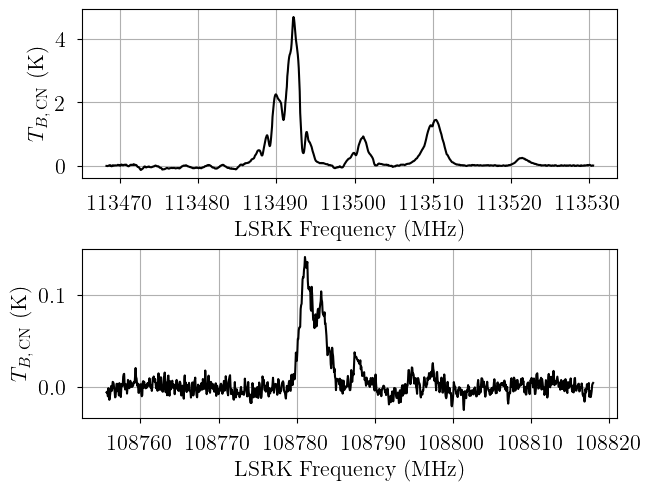

In [3]:
from bayes_spec import SpecData

data_12CN = np.genfromtxt("data_CN.tsv")
data_13CN = np.genfromtxt("data_13CN.tsv")

# estimate noise
noise_12CN = 1.4826 * np.median(np.abs(data_12CN[:, 0] - np.median(data_12CN[:, 0])))
noise_13CN = 1.4826 * np.median(np.abs(data_13CN[:, 0] - np.median(data_13CN[:, 0])))

obs_12CN = SpecData(
    1000.0 * data_12CN[:, 0],
    data_12CN[:, 1],
    noise_12CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_{B,\,\rm CN}$ (K)",
)
obs_13CN = SpecData(
    1000.0 * data_13CN[:, 0],
    data_13CN[:, 1],
    noise_13CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_{B,\,\rm CN}$ (K)",
)
data_12CN = {"observation": obs_12CN}
data = {"12CN": obs_12CN, "13CN": obs_13CN}

# Plot the data
fig, axes = plt.subplots(2, layout="constrained")
axes[0].plot(data["12CN"].spectral, data["12CN"].brightness, 'k-')
axes[1].plot(data["13CN"].spectral, data["13CN"].brightness, 'k-')
axes[0].set_xlabel(data["12CN"].xlabel)
axes[1].set_xlabel(data["13CN"].xlabel)
axes[0].set_ylabel(data["12CN"].ylabel)
_ = axes[1].set_ylabel(data["13CN"].ylabel)

## Determine Number of Clouds

The CN data has much greater signal-to-noise, so let's use those data to constrain the number of "cloud" components.

In [8]:
from bayes_cn_hfs import get_molecule_data
import astropy.constants as c

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)
mass_12CN = (12*c.m_p + 14*c.m_p).to('g').value

# Hyperfine anomaly transitions
mol_data_12CN['anomalous'] = [freq in [113499.643, 113508.934] for freq in mol_data_12CN['freq']]

In [9]:
from bayes_cn_hfs import HFSAnomalyModel
from bayes_spec import Optimize

max_n_clouds = 7
baseline_degree = 2
opt = Optimize(
    HFSAnomalyModel,
    data_12CN,
    mol_data=mol_data_12CN,
    mass=mass_12CN, # molecular mass (g)
    max_n_clouds=max_n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True,
)
opt.add_priors(
    prior_log10_N = [14.0, 0.5], # mean and width of log10(N_u) prior (cm-2)
    prior_log10_temp = [1.0, 0.1], # mean and width of log10(T) prior (K)
    prior_nonthermal_fwhm = 2.0, # width of nonthermal FWHM prior (km/s)
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_rms = 0.1, # width of spectral rms prior (K)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normalized polynomial baseline coeffs
    prior_hyperfine_anomaly = 0.1, # width of the hyperfine anomaly prior
    ordered = False, # do not assume optically-thin
)
opt.add_likelihood()

In [10]:
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 1e-2,
}
sample_kwargs = {
    "chains": 4,
    "cores": 4,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.8},
}
opt.fit_all(**fit_kwargs)

Null hypothesis BIC = 8.561e+05
Approximating n_cloud = 1 posterior...


KeyboardInterrupt: 

Sampling: [observation]


Output()

array([[<Axes: xlabel='LSRK Frequency (MHz)', ylabel='$T_{B,\\,\\rm CN}$ (K)'>]],
      dtype=object)

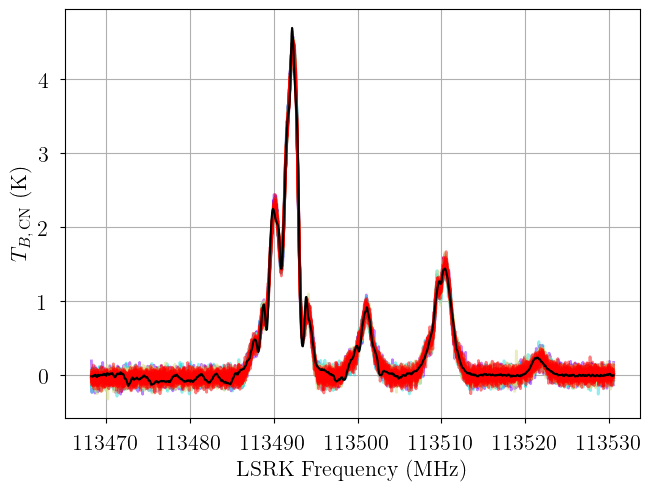

In [6]:
from bayes_spec.plots import plot_predictive

posterior = opt.best_model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(opt.best_model.data, posterior.posterior_predictive)

Let's also inspect the residuals.

Text(0, 0.5, '$T_{B,\\,\\rm CN}$ (K)')

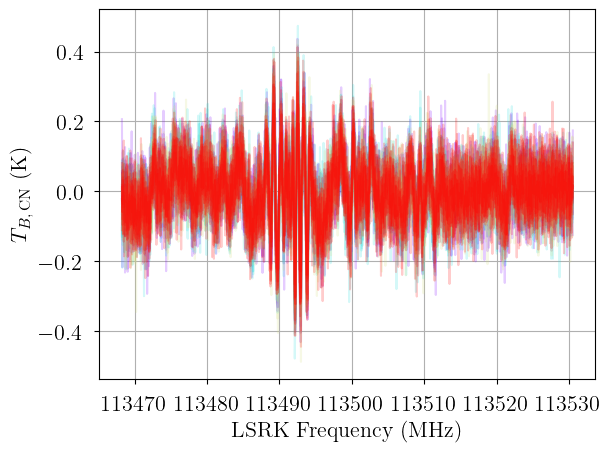

In [7]:
# Plot the residuals
fig, ax = plt.subplots()

color = iter(plt.cm.rainbow(np.linspace(0, 1, len(posterior.posterior_predictive.chain))))
for chain in posterior.posterior_predictive.chain:
    c = next(color)
    ax.plot(
        data["12CN"].spectral,
        posterior.posterior_predictive["observation"].sel(
            chain=chain, draw=slice(None, None, 1)
        ).T - data["12CN"].brightness[:, None],
        "-",
        color=c,
        alpha=0.2,
    )
ax.set_xlabel(data["12CN"].xlabel)
ax.set_ylabel(data["12CN"].ylabel)

In [8]:
pm.summary(opt.best_model.trace.solution_0)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
fwhm[0],2.851,0.081,2.688,2.992,0.014,0.010,31.0,543.0,1.13
fwhm[1],2.470,0.058,2.381,2.570,0.020,0.015,9.0,118.0,1.38
fwhm[2],1.766,0.063,1.627,1.877,0.004,0.003,290.0,166.0,1.11
fwhm[3],4.000,0.229,3.526,4.415,0.039,0.028,34.0,67.0,1.11
fwhm[4],2.983,0.115,2.779,3.191,0.019,0.014,39.0,303.0,1.08
"hyperfine_anomaly[113123.3687, 0]",1.210,0.105,0.978,1.381,0.012,0.009,72.0,125.0,1.04
"hyperfine_anomaly[113123.3687, 1]",1.186,0.106,0.960,1.344,0.017,0.012,43.0,62.0,1.06
"hyperfine_anomaly[113123.3687, 2]",1.074,0.092,0.899,1.248,0.007,0.005,183.0,1023.0,1.06
"hyperfine_anomaly[113123.3687, 3]",1.032,0.093,0.854,1.201,0.010,0.007,89.0,125.0,1.16
"hyperfine_anomaly[113123.3687, 4]",1.004,0.090,0.866,1.198,0.018,0.013,29.0,445.0,1.09


## Model Definition

In [9]:
from bayes_cn_hfs import CNRatioAnomalyModel

# Initialize and define the model
n_clouds = 5
baseline_degree = 2
model = CNRatioAnomalyModel(
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [14.0, 0.2], # mean and width of log10(12CN N) prior (cm-2)
    prior_log10_temp = [1.0, 0.1], # mean and width of log10(T) prior (K)
    prior_nonthermal_fwhm = 1.0, # width of nonthermal FWHM prior (km/s)
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_ratio_13C_12C = 0.01, # width of the 13C/12C prior
    prior_rms_12CN = 0.1, # width of the 12CN spectral rms prior (K)
    prior_rms_13CN = 0.1, # width of the 13CN spectral rms prior (K)
    prior_baseline_coeffs_12CN = [1.0, 1.0, 1.0], # width of polynomial baseline coefficients prior
    prior_baseline_coeffs_13CN = [1.0, 1.0, 1.0], # width of polynomial baseline coefficients prior
    prior_hyperfine_anomaly_12CN = 0.05, # width of the 12CN hyperfine anomaly prior
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

## Variational Inference

In [10]:
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)

Output()

Convergence achieved at 4800
Interrupted at 4,799 [4%]: Average Loss = 1,923.9


In [11]:
# posterior samples stored in model.trace.posterior
pm.summary(model.trace.posterior, var_names=model.deterministics)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log10_N_12CN[0],14.166,0.005,14.157,14.174,0.000,0.000,869.0,905.0,NaN
log10_N_12CN[1],14.032,0.010,14.014,14.050,0.000,0.000,884.0,820.0,NaN
log10_N_12CN[2],14.067,0.006,14.056,14.077,0.000,0.000,1011.0,826.0,NaN
log10_N_12CN[3],13.869,0.009,13.853,13.888,0.000,0.000,972.0,904.0,NaN
log10_N_12CN[4],13.919,0.008,13.904,13.935,0.000,0.000,994.0,613.0,NaN
log10_temp[0],1.148,0.013,1.123,1.170,0.000,0.000,936.0,871.0,NaN
log10_temp[1],1.051,0.026,1.005,1.100,0.001,0.001,915.0,948.0,NaN
log10_temp[2],1.190,0.017,1.160,1.223,0.001,0.000,945.0,1023.0,NaN
log10_temp[3],1.115,0.028,1.056,1.163,0.001,0.001,917.0,915.0,NaN
log10_temp[4],1.012,0.042,0.939,1.091,0.001,0.001,1005.0,894.0,NaN


Sampling: [12CN, 13CN]


Output()

array([[<Axes: xlabel='LSRK Frequency (MHz)', ylabel='$T_{B,\\,\\rm CN}$ (K)'>],
       [<Axes: xlabel='LSRK Frequency (MHz)', ylabel='$T_{B,\\,\\rm CN}$ (K)'>]],
      dtype=object)

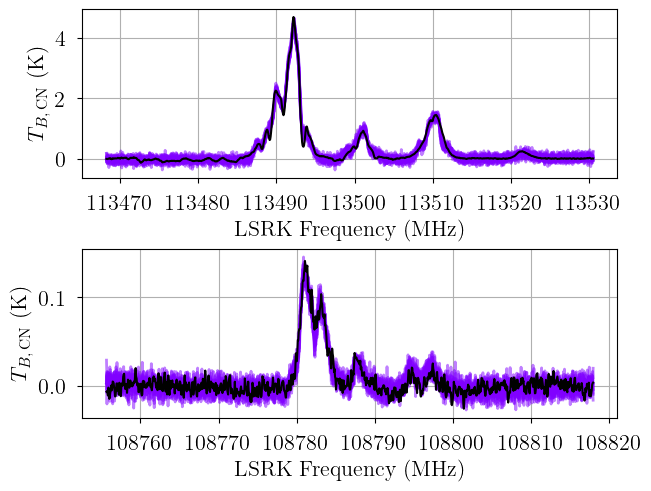

In [12]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
plot_predictive(model.data, posterior.posterior_predictive)

## MCMC

In [13]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 4800
Interrupted at 4,799 [4%]: Average Loss = 1,923.9
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [12CN_baseline_norm, 13CN_baseline_norm, log10_N_12CN_norm, log10_temp_norm, nonthermal_fwhm_norm, velocity_norm, ratio_13C_12C_norm, rms_12CN_norm, rms_13CN_norm, hyperfine_anomaly_12CN_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3898 seconds.


Runtime: 67.62 minutes


In [14]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


Sampling: [12CN, 13CN]


Output()

array([[<Axes: xlabel='LSRK Frequency (MHz)', ylabel='$T_{B,\\,\\rm CN}$ (K)'>],
       [<Axes: xlabel='LSRK Frequency (MHz)', ylabel='$T_{B,\\,\\rm CN}$ (K)'>]],
      dtype=object)

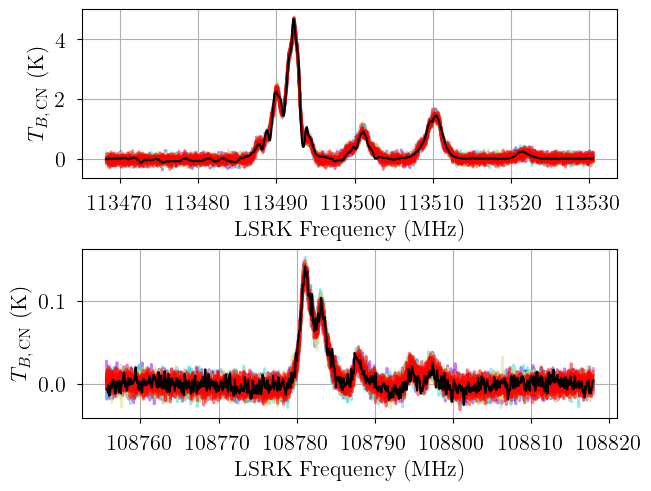

In [16]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
plot_predictive(model.data, posterior.posterior_predictive)

In [17]:
pm.summary(model.trace.solution_0)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
12CN_baseline_norm[0],-0.438,0.008,-0.453,-0.422,0.000,0.000,2469.0,3079.0,1.00
12CN_baseline_norm[1],0.072,0.014,0.047,0.097,0.000,0.000,5252.0,2884.0,1.00
12CN_baseline_norm[2],0.211,0.138,-0.054,0.460,0.003,0.002,2769.0,2556.0,1.00
13CN_baseline_norm[0],-0.505,0.017,-0.539,-0.476,0.000,0.000,3339.0,2542.0,1.00
13CN_baseline_norm[1],-0.106,0.032,-0.165,-0.044,0.000,0.000,8244.0,2859.0,1.00
13CN_baseline_norm[2],3.035,0.295,2.509,3.598,0.005,0.004,3475.0,3010.0,1.00
"hyperfine_anomaly_12CN[113123.3687, 0]",1.057,0.049,0.966,1.150,0.001,0.000,5623.0,2939.0,1.00
"hyperfine_anomaly_12CN[113123.3687, 1]",1.021,0.048,0.928,1.108,0.001,0.000,5090.0,2992.0,1.00
"hyperfine_anomaly_12CN[113123.3687, 2]",1.010,0.047,0.915,1.096,0.001,0.000,5676.0,2449.0,1.00
"hyperfine_anomaly_12CN[113123.3687, 3]",1.012,0.048,0.921,1.101,0.001,0.000,6623.0,3025.0,1.00


array([[<Axes: title={'center': 'log10_N_12CN_norm'}>,
        <Axes: title={'center': 'log10_N_12CN_norm'}>],
       [<Axes: title={'center': 'log10_temp_norm'}>,
        <Axes: title={'center': 'log10_temp_norm'}>],
       [<Axes: title={'center': 'nonthermal_fwhm_norm'}>,
        <Axes: title={'center': 'nonthermal_fwhm_norm'}>],
       [<Axes: title={'center': 'velocity_norm'}>,
        <Axes: title={'center': 'velocity_norm'}>],
       [<Axes: title={'center': 'ratio_13C_12C_norm'}>,
        <Axes: title={'center': 'ratio_13C_12C_norm'}>],
       [<Axes: title={'center': 'hyperfine_anomaly_12CN_norm'}>,
        <Axes: title={'center': 'hyperfine_anomaly_12CN_norm'}>],
       [<Axes: title={'center': '12CN_baseline_norm'}>,
        <Axes: title={'center': '12CN_baseline_norm'}>],
       [<Axes: title={'center': '13CN_baseline_norm'}>,
        <Axes: title={'center': '13CN_baseline_norm'}>],
       [<Axes: title={'center': 'rms_12CN_norm'}>,
        <Axes: title={'center': 'rms_12CN

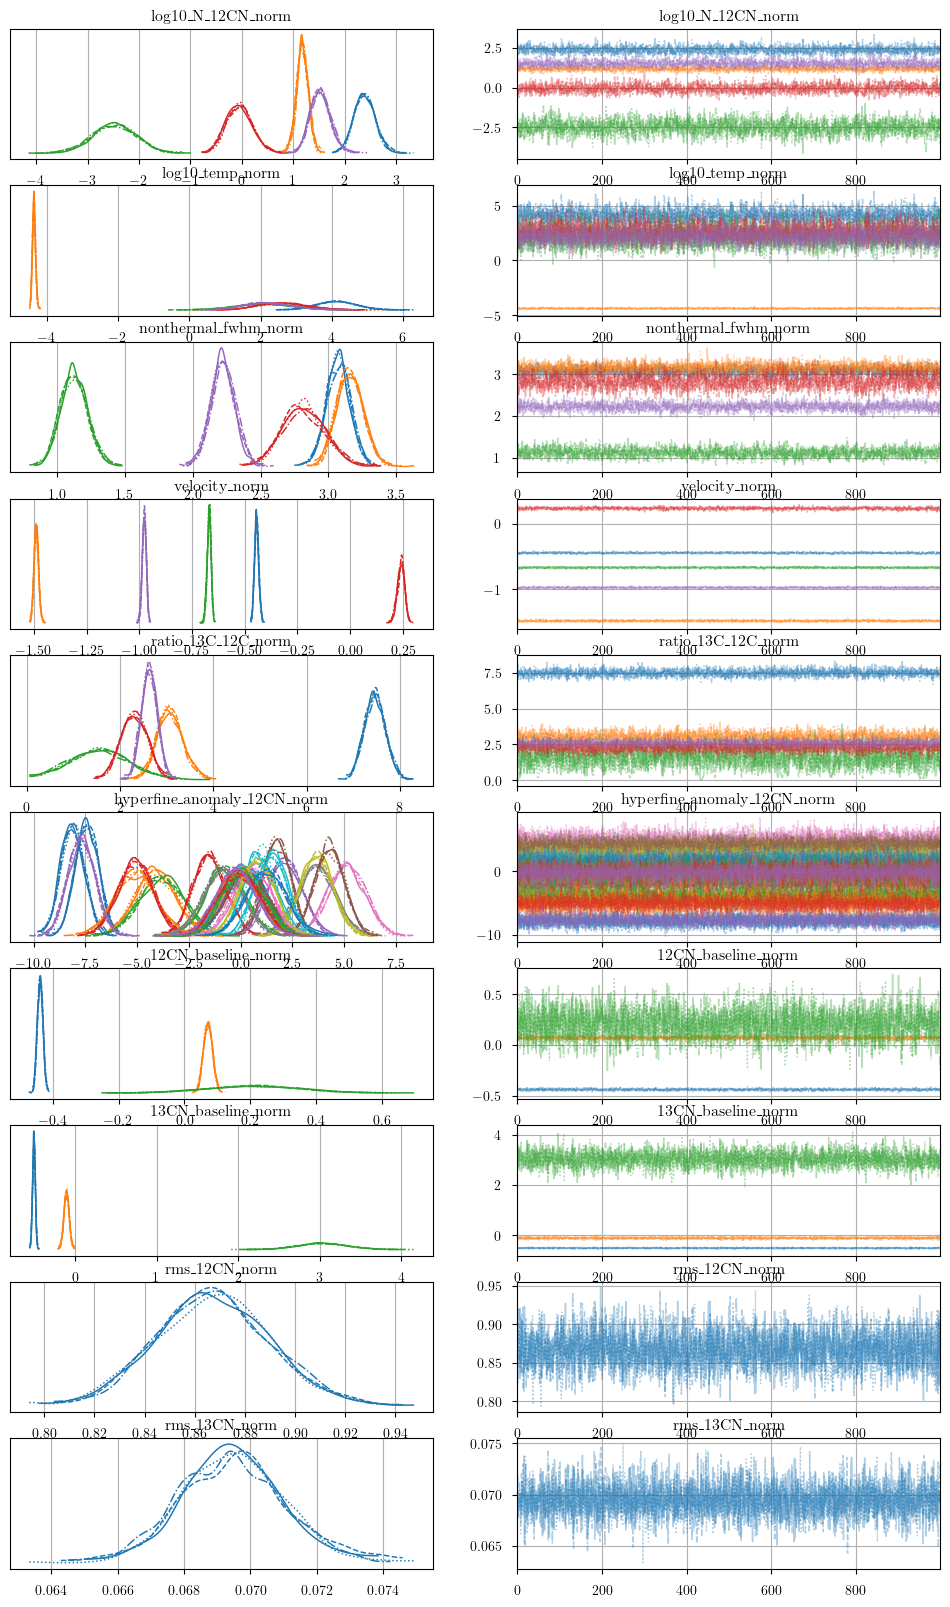

In [18]:
from bayes_spec.plots import plot_traces

plot_traces(model.trace.solution_0, model.cloud_params+model.baseline_params+model.hyper_params)

array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='log10_temp_norm'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='nonthermal_fwhm_norm'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='velocity_norm'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: xlabel='log10_N_12CN_norm', ylabel='ratio_13C_12C_norm'>,
        <Axes: xlabel='log10_temp_norm'>,
        <Axes: xlabel='nonthermal_fwhm_norm'>,
        <Axes: xlabel='velocity_norm'>,
        <Axes: xlabel='ratio_13C_12C_norm'>]], dtype=object)

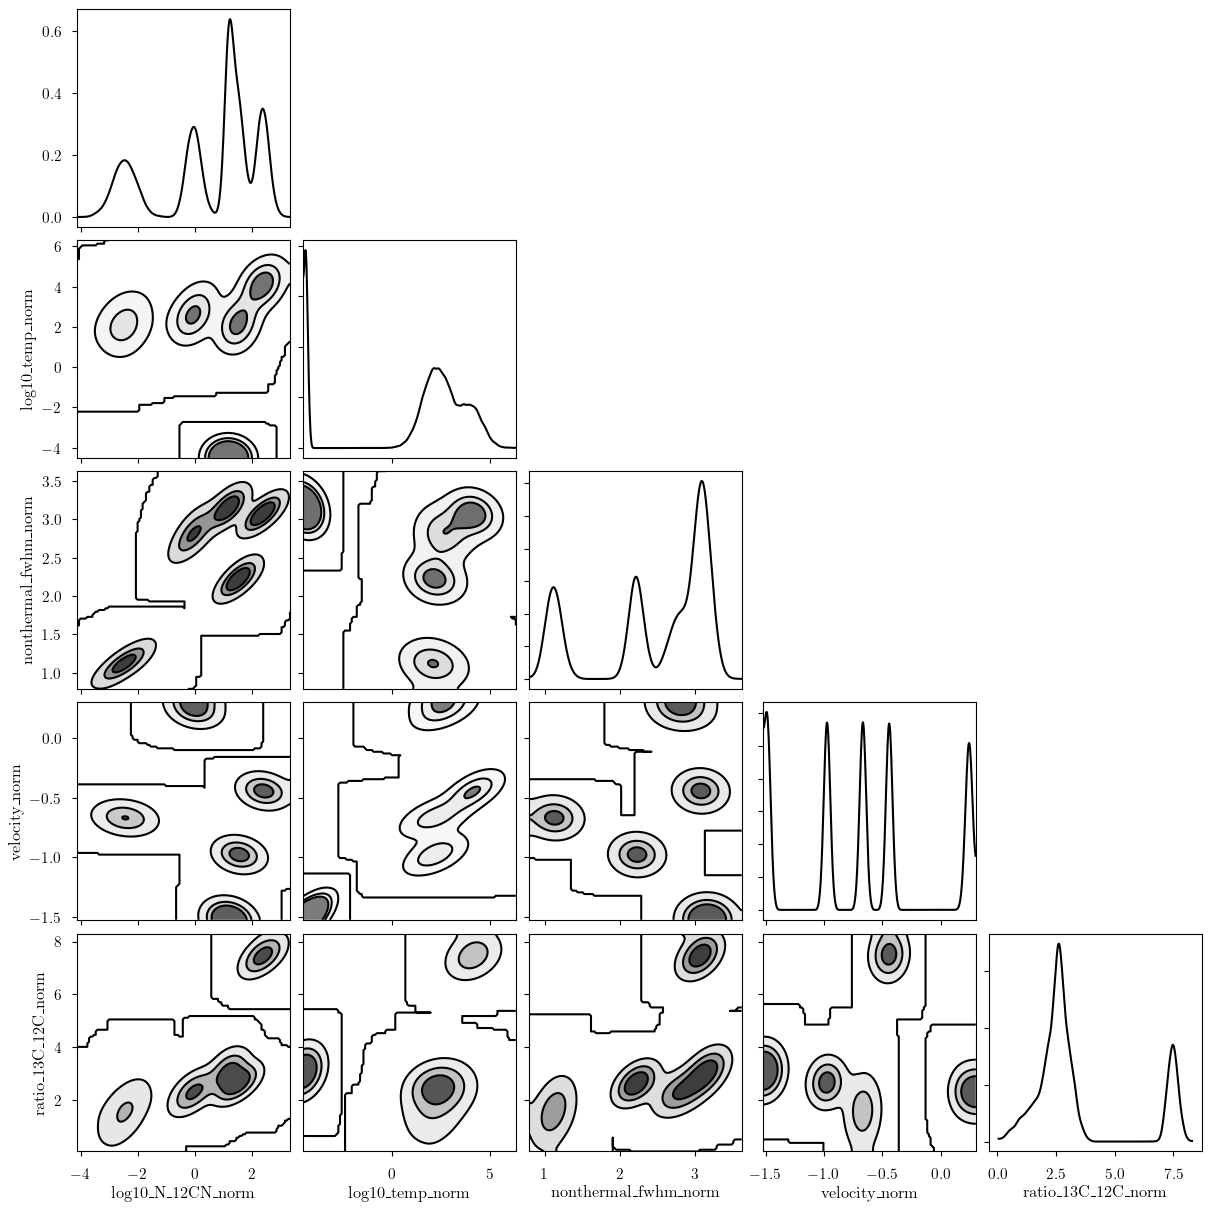

In [19]:
from bayes_spec.plots import plot_pair

var_names = [var_name for var_name in model.cloud_params if var_name not in ["hyperfine_anomaly_12CN_norm"]]
plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='hyperfine_anomaly_12CN_norm\n113144.19'>,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='hyperfine_anomaly_12CN_norm\n113170.535'>,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='hyperfine_anomaly_12CN_norm\n113191.325'>,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='hyperfine_anomaly_12CN_norm\n113488.142'>,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='hyperfine_anomaly_12CN_norm\n113490.985'>,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='hyperfine_anomaly_12CN_norm\n113499.643'>,
        <Axes

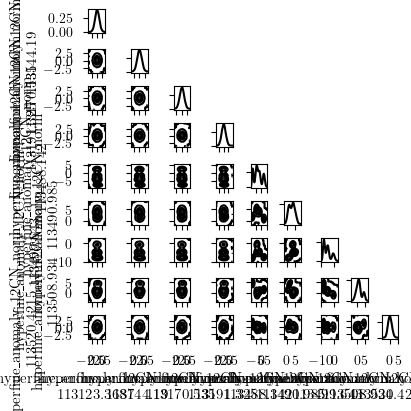

In [20]:
plot_pair(
    model.trace.solution_0, # samples
    ["hyperfine_anomaly_12CN_norm"], # var_names to plot
    labeller=model.labeller, # label manager
)